# Tutorial

## Overview

Welcome to aurora-asi-lib. This tutorial will guide you though the main functions in `aurora-asi-lib` (imported as `asilib`). 

First off, we need to import the necessary packages.

In [1]:
from datetime import datetime, timedelta
from IPython.display import Video
import numpy as np

import matplotlib.pyplot as plt
import asilib
import asilib.asi
import asilib.map

plt.style.use('dark_background')

print(f'asilib version: {asilib.__version__}')

asilib version: 0.16.2


First of all, you should know where the data and movies are saved to. This information is in `asilib.config` and can be changed with `python3 -m asilib config` to configure asilib.

In [2]:
asilib.config

{'ASILIB_DIR': WindowsPath('C:/Users/shumkms1/Documents/research/aurora-asi-lib/asilib'),
 'ASI_DATA_DIR': WindowsPath('C:/Users/shumkms1/asilib-data')}

As you can guess, `asilib.config['ASILIB_DIR']` is the directory where this code resides, `asilib.config['ASI_DATA_DIR']` is the directory where the data is saved to.

## Plot a single image

The core of asilib is the `asilib.Imager` class. It provides an intuitive interface to load, plot, animate, and analyze auroral images. Normally, you do not need to call `asilib.Imager()` directly. Instead, you initialize an `asilib.Imager` object via a ASI interface function, such as `asilib.asi.themis`, `asilib.asi.rego`, or `asilib.asi.trex_nir`. Let's see how this works by plotting a fisheye lens image from a THEMIS imager at Athabasca (ATHA). We will show the aurora studied in:

Liu, J., Lyons, L. R., Archer, W. E., Gallardo-Lacourt, B., Nishimura, Y., Zou, Y., … Weygand, J. M. (2018). Flow shears at the poleward boundary of omega bands  observed during conjunctions of Swarm and THEMIS ASI. Geophysical Research Letters, 45, 1218– 1227. https://doi.org/10.1002/2017GL076485

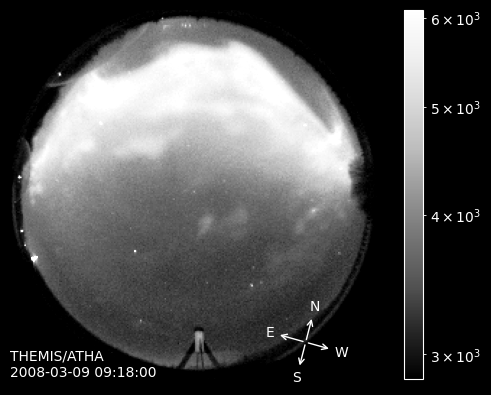

In [3]:
location_code = 'ATHA'
time = datetime(2008, 3, 9, 9, 18, 0)  # You can supply a datetime object or a ISO-formatted time string.

asi = asilib.asi.themis(location_code, time=time)
ax, im = asi.plot_fisheye(cardinal_directions='news')
plt.colorbar(im)
ax.axis('off');

That is it! By calling the `asilib.asi.themis()` function, we create an `asilib.Imager()` object---with uniform interface. In other words, plotting a fisheye image (`Imager.plot_fisheye()`) is the same for THEMIS, REGO, TREx, or any other ASI supported by asilib. This is what makes asilib so powerful.

It is also easy to map the ASI fisheye lens image to a geographic map using the `Imager.plot_map()` method. In the code box below, the first line creates a geographic map centered on Athabasca and the second line projects the image onto the map.

Note: If latitude or longitude bounds are not provided, `Imager.plot_map()` defaults to a map of North America.

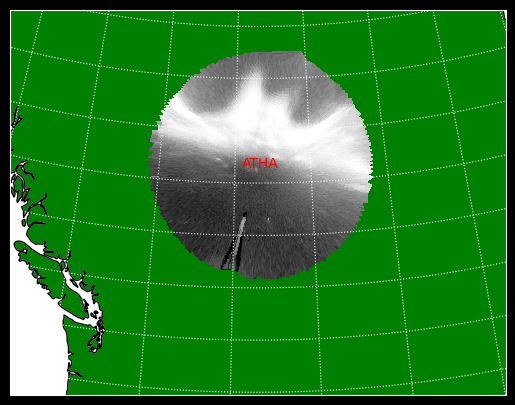

In [4]:
ax = asilib.map.create_map(lon_bounds=(-127, -100), lat_bounds=(45, 60))
asi.plot_map(ax=ax);

Notice that you did not need to explicitly download or load the data. The ASI Interface Function downloads the necessary image and skymap files, while `asilib.Imager()` loads data as needed, also known as the "lazy" mode. This preserves your computer's memory at the expense of processing speed. Alternatively, you can load all of the data into memory at once with the "eager" mode.

In [5]:
asi_data = asi.data

In [6]:
asi_data.times

datetime.datetime(2008, 3, 9, 9, 18, 0, 50605)

In [7]:
asi_data.images.shape

(256, 256)

In [8]:
asi_data.images

array([[2536, 2616, 2554, ..., 2572, 2537, 2546],
       [2582, 2582, 2620, ..., 2562, 2613, 2608],
       [2544, 2560, 2568, ..., 2588, 2526, 2550],
       ...,
       [2525, 2546, 2553, ..., 2612, 2541, 2629],
       [2545, 2596, 2698, ..., 2510, 2568, 2569],
       [2502, 2577, 2602, ..., 2514, 2617, 2576]], dtype=uint16)

## Plot a Keogram

`Imager.plot_keogram()` plots a keogram through the meridian. Alternatively, you can specify a custom path using (latitude, longitude coordinates).

By default, the y-axis is geographic latitude. If you set `aacgm=True`, the keogram's vertical axis will be magnetic latitude estimated using the [aacgmv2](https://github.com/aburrell/aacgmv2) Python package. It implements the Altitude-adjusted corrected geomagnetic coordinates defined in [Shepherd 2014](https://doi.org/10.1002/2014JA020264).

THEMIS ATHA keogram: |##################################################| 100%


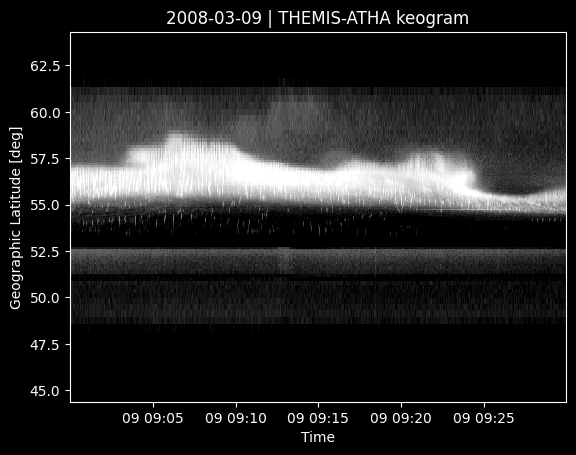

In [9]:
time_range = [datetime(2008, 3, 9, 9, 0, 0), datetime(2008, 3, 9, 9, 30, 0)]
asi2 = asilib.asi.themis(location_code, time_range=time_range)
asi2.plot_keogram()
plt.xlabel('Time'); plt.ylabel('Geographic Latitude [deg]');

THEMIS ATHA keogram: |##################################################| 100%


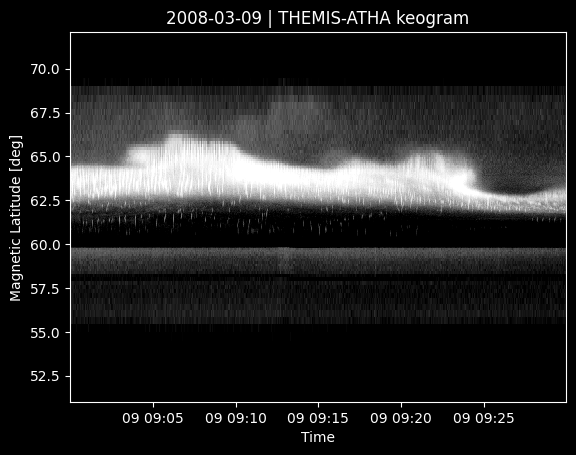

In [10]:
asi2.plot_keogram(aacgm=True)
plt.xlabel('Time'); plt.ylabel('Magnetic Latitude [deg]');

In making the last three plots, the geographic latitudes correspond to pixels mapped to a specified auroral emission altitude. This altitude is set with the `alt` kwarg passed into the ASI Interface Function. The default altitude is 110 km for THEMIS and 230 km for REGO.

If you pick an incorrect `alt`, you will get an error.

In [11]:
try:
    asilib.asi.themis(location_code, time_range=time_range, alt=100)
except AssertionError as err:
    print('AssetionError:', err)

AssetionError: 100 km is not in the valid skymap altitudes: [ 90. 110. 150.] km.


These auroral emission altitudes are defined in the skymap files.

## Skymap calibration files
You may wonder how the image's pixel values were mapped to geographic latitude. This is done via the skymap calibration files. They contain four arrays that map the ASI's pixels to:

- `el` - elevation
- `az` - azimuth
- `lat` - latitude
- `lon` - longitude

These skymaps are essential for mapping images onto a geographic map, and for calculating the auroral intensity for conjunction studies.

In [12]:
asi2.skymap.keys()

dict_keys(['lat', 'lon', 'alt', 'el', 'az', 'path'])

The ASI maintainers often move or adjust their ASIs, after which a new skymap is often produced. Therefore, the relevant skymap is the one taken right before the images that were loaded. By default, asilib downloads all of the skymaps. The skymap file name below indicates that it is valid for images taken between 1 March 2007 and 22 May 2009.

In [13]:
asi2.skymap['path'].name

'themis_skymap_atha_20070301-20090522_vXX.sav'

Lastly, the `Imager` instance has a `meta` attribute that contains the ASI metadata such as location, pixel resolution, and cadence. 

In [14]:
asi2.meta

{'array': 'THEMIS',
 'location': 'ATHA',
 'lat': 54.720001220703125,
 'lon': -113.30999755859375,
 'alt': 0.676,
 'cadence': 3,
 'resolution': (256, 256)}

You can also see human-readable summary of the ASI by printing it.

In [15]:
print(asi2)

A THEMIS-ATHA Imager. time_range=[datetime.datetime(2008, 3, 9, 9, 0), datetime.datetime(2008, 3, 9, 9, 30)]


## Mapping multiple all-sky images

You can plot one image from multiple ASI locations using a for-loop. In the following example, we will replicate Fig. 2b from:

Donovan, E., Liu, W., Liang, J., Spanswick, E., Voronkov, I., Connors, M., ... & Rae, I. J. (2008). Simultaneous THEMIS in situ and auroral observations of a small substorm. Geophysical Research Letters, 35(17).

c:\Users\shumkms1\AppData\Local\anaconda3\envs\asilib_dev_cartopy\Lib\site-packages\scipy\io\_idl.py:279: UserWarning: Not able to verify number of bytes from header
  warnings.warn("Not able to verify number of bytes from header")
c:\Users\shumkms1\AppData\Local\anaconda3\envs\asilib_dev_cartopy\Lib\site-packages\scipy\io\_idl.py:279: UserWarning: Not able to verify number of bytes from header
  warnings.warn("Not able to verify number of bytes from header")


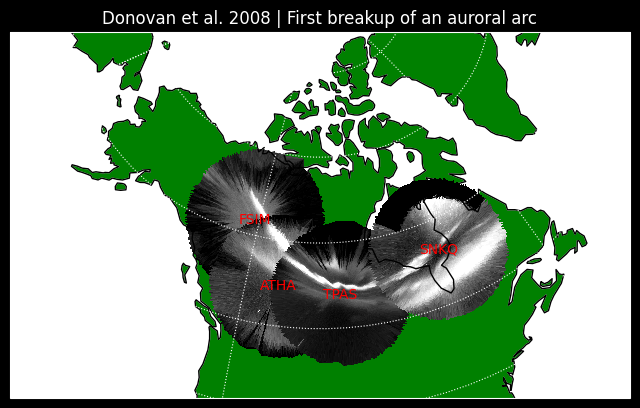

In [16]:
time = datetime(2007, 3, 13, 5, 8, 45)
location_codes = ['FSIM', 'ATHA', 'TPAS', 'SNKQ']
map_alt = 110
min_elevation = 2  # Plot only pixels observed above some minimum elevation.

bx = asilib.map.create_map()

for location_code in location_codes:
    asi = asilib.asi.themis(location_code, time=time, alt=map_alt)
    asi.plot_map(ax=bx, min_elevation=min_elevation)

bx.set_title('Donovan et al. 2008 | First breakup of an auroral arc')
plt.show()

## Working with multiple images

`asilib.Imager` supports slicing by time. In the example below, we plot a few fisheye and mapped images of STEVE that was observed by the REGO imagers.

Gallardo-Lacourt, B., Nishimura, Y., Donovan, E., Gillies, D. M., Perry, G. W., Archer, W. E., et al. (2018). A statistical analysis of STEVE. Journal of Geophysical Research: Space Physics, 123, 9893– 9905. https://doi.org/10.1029/2018JA025368

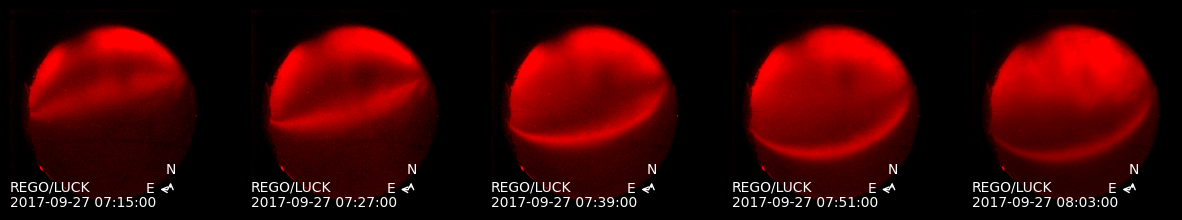

In [17]:
time_range = [datetime(2017, 9, 27, 7, 15), datetime(2017, 9, 27, 8, 15)]
n_plots = 5
dt = int((time_range[1]-time_range[0]).total_seconds()/n_plots)
image_times = [time_range[0]+timedelta(seconds=i*dt) for i in range(n_plots)]

asi = asilib.asi.rego('LUCK', time_range=time_range)

fig, cx = plt.subplots(1, n_plots, figsize=(15, 8))

for montage_time, cx_i in zip(image_times, cx):
    filtered_asi = asi[montage_time]
    filtered_asi.plot_fisheye(ax=cx_i)
    cx_i.axis('off')

## Animate images

Let's now make a simple fisheye lens movie of a substorm using `Imager.animate_fisheye()`.

In [18]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)
asi.animate_fisheye(overwrite=True, ffmpeg_params={'loglevel':'quiet'})
plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/e6147ff1a3309c602c1aa48711ebc8a90a7863e1/docs/_static/'
    '20150326_060700_062957_themis_fsmi.mp4?raw=true')

20150326_060700_063000_themis_fsmi_fisheye.mp4: |#######################| 100%
Aanimation saved to C:\Users\shumkms1\asilib-data\animations\20150326_060700_063000_themis_fsmi_fisheye.mp4


Animating images projected onto a map is also straightforward. 

In [19]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)

lat_bounds = (asi.meta['lat']-7, asi.meta['lat']+7)
lon_bounds = (asi.meta['lon']-10, asi.meta['lon']+10)

dx = asilib.make_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
plt.subplots_adjust(top=0.99, bottom=0.05, left=0.05, right=0.99)

asi.animate_map(overwrite=True, ax=dx, ffmpeg_params={'loglevel':'quiet'})

plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/main/docs/_static/20150326_060700_062957_themis_fsmi_map.mp4?raw=true')

20150326_060700_063000_themis_fsmi_map.mp4: |###########################| 100%
Aanimation saved to C:\Users\shumkms1\asilib-data\animations\20150326_060700_063000_themis_fsmi_map.mp4


If you need to annotate the animation, `asilib.Imager` has `animate_fisheye_gen` and `animate_map_gen` generator functions. After it plots each auroral image, it allows you to superpose your data.

Note: in each iteration, these methods do not clear the subplot; all plot objects persist unless you explicitly remove them 

In [27]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 10, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)

lat_bounds = (asi.meta['lat']-7, asi.meta['lat']+7)
lon_bounds = (asi.  meta['lon']-10, asi.meta['lon']+10)

ex = asilib.make_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
plt.subplots_adjust(top=0.99, bottom=0.05, left=0.05, right=0.99)
gen = asi.animate_map_gen(overwrite=True, ax=ex, ffmpeg_params={'loglevel':'quiet'}, asi_label=False)

for time, image, ax, im in gen:
    if 'time_label' in locals():
        # This is one way I found to clean up an added plotting object. 
        time_label.remove()
    time_label = ex.text(0.99, 0.99, f'location: {location_code} | time: {time}', 
                         ha='right', va='top', transform=ex.transAxes, fontsize=15)

plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/main/docs/_static/20150326_061000_062957_themis_fsmi_map.mp4?raw=true')

20150326_061000_063000_themis_fsmi_map.mp4: |###########################| 100%
Aanimation saved to C:\Users\shumkms1\asilib-data\animations\20150326_061000_063000_themis_fsmi_map.mp4


## Satellite conjunction

In this last section, we put everything together to animate a conjunction between a satellite and an imager. We will calculate the auroral intensity at the satellite's footprint using two methods:
1. Intensity from the nearest pixel, and
2. Mean intensity for the pixels in a 20x20 km area at the 110 km emission altitude.

Be forewarned, this example is long!

In [30]:
location_code = 'RANK'
alt=110
time_range = (datetime(2017, 9, 15, 2, 32, 0), datetime(2017, 9, 15, 2, 35, 0))
asi = asilib.asi.themis(location_code, time_range=time_range, alt=alt)

### Satellite footprint
Now we define an orbit path of a low Earth orbiting satellite (i.e. its footprint). This is a north-south satellite track oriented to the east of the THEMIS/RANK imager. In this context, `lla` stands for the `(latitude, longitude, altitude)` coordinates.

In [34]:
n = int((time_range[1] - time_range[0]).total_seconds() / 3)  # 3 second cadence.
lats = np.linspace(asi.meta["lat"] + 5, asi.meta["lat"] - 5, n)
lons = (asi.meta["lon"] - 0.5) * np.ones(n)
alts = alt * np.ones(n)
sat_lla = np.array([lats, lons, alts]).T
sat_time = asi.data.times

Create an `asilib.Conjunction()` object that handles mapping between the satellite and the imager. It takes in an `Imager` instance and arrays of the satellite times and LLA coordinates.

In [33]:
conjunction_obj = asilib.Conjunction(asi, (sat_time, sat_lla))

Now, here are two steps that we are ignoring that you'll likely need to implement:

1. Map the satellite's LLA coordinates along the magnetic field line from the satellite altitude down to 110 km (or whatever you chose for the `alt` kwarg.) This is done via `Conjunction.lla_footprint()` that requires the IRBEM library. IRBEM can be hard to install; in the future, I plan to change remove IRBEM in favor of geopack (or a similar package).
2. Normally the satellite LLA time stamps are not the same as the ASI. In that case you will need to call `Conjunction.interp_sat()` to interpolate the LLA coordinates to the ASI timestamps. Note: this method does not handle interpolation well across the anti-meridian (-180/180 degree longitude). If it detects that you're interpolating over it, it will issue a warning. 

### Nearest pixel intensity

In [40]:
sat_azel, sat_azel_pixels = conjunction_obj.map_azel()
nearest_pixel_intensity = conjunction_obj.intensity(box=None)

### Mean pixel intensity in a 20x20 km area. 

The mean intensity is calculated with a masked array. It contains `np.nan` outside the 20x20 km area, and 1s inside. 

In [39]:
area_intensity = conjunction_obj.intensity(box=(10, 10))

# You don't need to calculate the area mask if you just need the intensity, but this is useful if you 
# want to animate and visualize the area
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0

The following code block contains many steps.

1. We create three subplots and initialize the animation generator.
2. We loop over each image.
    - In the first subplot plot the entire satellite footprint using the `sat_azel_pixels` array.
    - In the first subplot plot the instantaneous footprint. 
    - In the first subplot plot the 20x20 km area contour.
    - In the second and third subplots plot the auroral intensity from a) the nearest pixel, and b) the 20x20 km area.
    - In the second and third subplots plot a vertical line at the current time.
    - Annotate the first subplot.

In [42]:
fig, ax = plt.subplots(
    3, 1, figsize=(7, 10), gridspec_kw={'height_ratios': [4, 1, 1]}, constrained_layout=True
)
ax[1].set(ylabel='ASI intensity\nnearest pixel [counts]')
ax[2].set(xlabel='Time', ylabel='ASI intensity\n10x10 km area [counts]')

gen = asi.animate_fisheye_gen(
    ax=ax[0], azel_contours=True, overwrite=True, cardinal_directions='news'
)

for i, (time, image, _, im) in enumerate(gen):
    # Plot the entire satellite track, its current location, and a 20x20 km box
    # around its location.
    ax[0].plot(sat_azel_pixels[:, 0], sat_azel_pixels[:, 1], 'red')
    ax[0].scatter(sat_azel_pixels[i, 0], sat_azel_pixels[i, 1], c='red', marker='o', s=50)
    ax[0].contour(area_mask[i, :, :], levels=[0.99], colors=['yellow'])

    if 'vline1' in locals():
        vline1.remove()
        vline2.remove()  
        text_obj.remove()
    else:
        # Plot the ASI intensity along the satellite path
        ax[1].plot(sat_time, nearest_pixel_intensity)
        ax[2].plot(sat_time, area_intensity)
    vline1 = ax[1].axvline(time, c='b')
    vline2 = ax[2].axvline(time, c='b')

    # Annotate the location_code and satellite info in the top-left corner.
    location_code_str = (
        f'THEMIS/{location_code} '
        f'LLA=({asi.meta["lat"]:.2f}, '
        f'{asi.meta["lon"]:.2f}, {asi.meta["alt"]:.2f})'
    )
    satellite_str = f'Satellite LLA=({sat_lla[i, 0]:.2f}, {sat_lla[i, 1]:.2f}, {sat_lla[i, 2]:.2f})'
    text_obj = ax[0].text(
        0,
        1,
        location_code_str + '\n' + satellite_str,
        va='top',
        transform=ax[0].transAxes,
        color='red',
    )
plt.close()

20170915_023200_023500_themis_rank_fisheye.mp4: |###################### | 97%
Aanimation saved to C:\Users\shumkms1\asilib-data\animations\20170915_023200_023500_themis_rank_fisheye.mp4


In [43]:
# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/main/docs/_static/20170915_023200_023457_themis_rank.mp4?raw=true')